<a href="https://colab.research.google.com/github/shhra/toy-example/blob/master/notebooks/Car_Data_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/My\ Drive/ai/kaggle.json /content/kaggle.json
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
# !kaggle datasets download -d mirosval/personal-cars-classifieds
# !unzip -q personal-cars-classifieds.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 96% 85.0M/88.2M [00:01<00:00, 47.9MB/s]
100% 88.2M/88.2M [00:01<00:00, 55.4MB/s]


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

In [0]:
data = pd.read_csv("all_anonymized_2015_11_2017_03.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Lets see that we have got. 
We will use data.head() to see information about our data

We will start by printing how many rows are there, then we will see the columns and their name

In [0]:
print(f'There are {data.shape[0]} rows in this data set')
print(f"Each row of the data has following columns:")
for name in data.columns.values:
    print(name)

There are 3552912 rows in this data set
Each row of the data has following columns:
maker
model
mileage
manufacture_year
engine_displacement
engine_power
body_type
color_slug
stk_year
transmission
door_count
seat_count
fuel_type
date_created
date_last_seen
price_eur


## Before Diving In
Let's see what the author has got to say about the data. 

    maker - normalized all lowercase
    model - normalized all lowercase
    mileage - in KM
    manufacture_year
    engine_displacement - in ccm
    engine_power - in kW
    body_type - almost never present, but I scraped only personal cars, no motorcycles or utility vehicles
    color_slug - also almost never present
    stk_year - year of the last emission control
    transmission - automatic or manual
    door_count
    seat_count
    fuel_type - gasoline, diesel, cng, lpg, electric
    date_created - when the ad was scraped
    datelastseen - when the ad was last seen. Our policy was to remove all ads older than 60 days
    price_eur - list price converted to EUR

This shows that there are different features that describe the car. Our task here is to explore the data so that we can understand how these features interplay when it comes to determining the price of the car.

Our first task will be understanding the missing value of the data.

In [0]:
data.isnull().sum()

maker                   518915
model                  1133361
mileage                 362584
manufacture_year        370578
engine_displacement     743414
engine_power            554877
body_type              1122914
color_slug             3343411
stk_year               1708156
transmission            741630
door_count              614373
seat_count              749489
fuel_type              1847606
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64

Out of 3.5M data, it seems that there are certain features that people don't care about. Such as **model of the car, type of car body, color of the car and fuel type**. 
With this information, we can simply drop the color column, because that is relatively irrelevant to us at this point. We will explore the remaining features with large missing values.

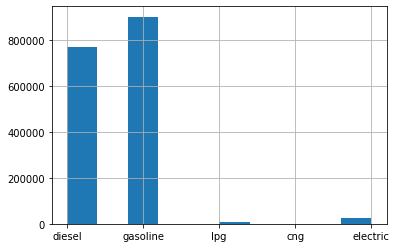

In [0]:
data.fuel_type.hist()

We can clearly see that majority of the vehicles we have are diesel and gasoline. Lets visualize the plot of for diesel and gasoline.

In [0]:
def price_stats(df, column_name, data):
  item = df[df[column_name] == data]
  print(f"The median price for {data} cars is {item.price_eur.median()}. \
The mean is {item.price_eur.mean()} with deviation of {item.price_eur.std()}")


price_stats(data, "fuel_type", "gasoline")
price_stats(data, "fuel_type", "diesel")


The median price for gasoline cars is 4001.22. The mean is 17911.719578493598 with deviation of 723824.0050526775
The median price for diesel cars is 10924.39. The mean is 13803.320890715553 with deviation of 105322.80629674725


Clearly this shows that there are outliers that are present within our data. 




For any unknown car maker, we are going to drop the data. Because that feels irrelevant to us. First let's have a look at those data and price

In [0]:
unknown_maker = data[data['maker'].isnull()]
print(unknown_maker.shape[0])
print(f"The median price for is {unknown_maker.price_eur.median()}. \
The mean is {unknown_maker.price_eur.mean()} with deviation of {unknown_maker.price_eur.std()}")

518915
The median price for is 6991.04. The mean is 547019.720371013 with deviation of 378961216.31788516


In [0]:
unknown_maker.isnull().sum()

maker                  518915
model                  518915
mileage                 80323
manufacture_year        72806
engine_displacement    151342
engine_power           138405
body_type              313867
color_slug             502485
stk_year                86018
transmission           148823
door_count              55184
seat_count              56981
fuel_type               96101
date_created                0
date_last_seen              0
price_eur                   0
dtype: int64

This clearly hints us that these data are irrelevant to us. Having such huge deviation will only affect our data. Therefore we can safely remove the We have the price for every unknown car manufacturer, but there is no relevant data to support it, other than manufacture year and engine information. Even these data are missing.


In [0]:
data = data.dropna(subset=['maker'])
data.isnull().sum()

maker                        0
model                   614446
mileage                 282261
manufacture_year        297772
engine_displacement     592072
engine_power            416472
body_type               809047
color_slug             2840926
stk_year               1622138
transmission            592807
door_count              559189
seat_count              692508
fuel_type              1751505
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64

We have already reduced the significant information of missing value from the dataset. Now we can use maker and engine power to generate fill in the value for model. Lets see number of unique values in each column. Before that lets drop the features of color.

In [0]:
data = data.drop('color_slug', axis=1)

Once we dropped color data, we can now see the unique values in all our columns


In [0]:
for each in data.columns.values:
  uniques = len(data[each].unique())
  print(f"There are {uniques} different values for {each}.")

There are 46 different values for maker.
There are 1013 different values for model.
There are 237578 different values for mileage.
There are 1562 different values for manufacture_year.
There are 6274 different values for engine_displacement.
There are 606 different values for engine_power.
There are 10 different values for body_type.
There are 261 different values for stk_year.
There are 3 different values for transmission.
There are 26 different values for door_count.
There are 74 different values for seat_count.
There are 6 different values for fuel_type.
There are 3033997 different values for date_created.
There are 2903510 different values for date_last_seen.
There are 206265 different values for price_eur.


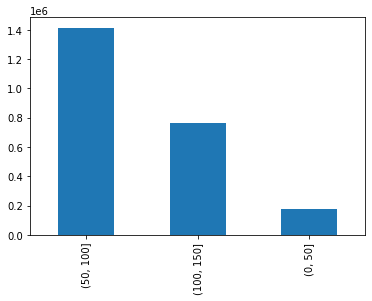

In [0]:
power_levels = pd.cut(data['engine_power'], range(0, 200, 50))
power_levels.value_counts().plot(kind='bar')


Signifcant of our data has engine power from 50KW to 150KW. Based on our manufacturer and there corresponding model we can fill this data. Lets see which top 5 manufacturer has the highest count.

In [0]:
data['maker'].value_counts().head()

skoda            313830
volkswagen       297256
bmw              266731
mercedes-benz    251966
audi             248602
Name: maker, dtype: int64

Let's explore our data based on car manufacturers. That way we can find some good ways to replace fill in the missing values and deal with outliers.


<BarContainer object of 46 artists>

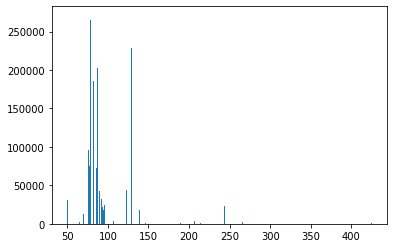

In [0]:
grouped = data.groupby('maker')
df = grouped['engine_power'].describe().reset_index()
df = df.sort_values('mean', ascending=True)
plt.bar(df['mean'], df['count'])

This bar plot reveals several the the distribution of the average engine power on our data. If seems that the data falls under two categories, on for which power is less than 100 and another for which power is close to 150. We can fillin these information based on the manufacturer. 

For each manufacturer's we will fill the missing value with the median value. for that manufacturer.


In [0]:
data['engine_power'] = grouped['engine_power'].transform(lambda x: x.fillna(x.median()))  

In [0]:
data.isnull().sum()

maker                        0
model                   614446
mileage                 282261
manufacture_year        297772
engine_displacement     592072
engine_power                 0
body_type               809047
stk_year               1622138
transmission            592807
door_count              559189
seat_count              692508
fuel_type              1751505
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64

Now lets use the information of engine power and pre-existing. First we will group the models based off maker and model. That we can access the engine and price for the each model made by the maker.

In [0]:
mm = data.groupby(['maker', 'model'])
uniques_power = mm['engine_power'].mean().reset_index()
uniques_price = mm['price_eur'].mean().reset_index()

In [0]:
estimated_model = pd.merge(uniques_power, uniques_price, how='outer')


Once we have general idea on how each model is priced and what is the engine power of each model we can use this to create a function.

The function should take maker, power and price and return. It first looks in the maker, then checks for the price closests to the given price. After that it checks for the power in similar range. And then it returns the model.


In [0]:
def fetch_model(maker, power, price):
  look_in = estimated_model[estimated_model['maker'] == maker]
  idx = look_in['price_eur'].sub(price).abs().idxmin()
  fprice = look_in.loc[idx].price_eur
  look_in_price = look_in[look_in.price_eur == fprice]
  idx = look_in_price['engine_power'].sub(power).abs().idxmin()
  fpower = look_in_price.loc[idx].engine_power
  final = look_in_price[look_in_price['engine_power'] == fpower].model.values[0]
  return final

In [0]:
data_grouped = data.groupby(['maker', 'engine_power', 'price_eur'])
test = data.iloc[1]

In [0]:
# models = data[data['model'].isnull()]
# models.shape
# data_grouped = models.groupby(['maker', 'engine_power', 'price_eur'])
# models.model = data_grouped['model'].transform(lambda x: x.fillna(fetch_model(x.name[0], x.name[1], x.name[2])))
models = pd.read_csv('/content/drive/My Drive/ai/data.csv', index_col='Unnamed: 0')
models.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,passat,97676.0,2010.0,1995.0,85.0,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


Once we have applied the function we can look on our data. It should now fix the missing model name. 

In [0]:
data.model = data.model.fillna(models.model)
data.isnull().sum()

maker                        0
model                        0
mileage                 282261
manufacture_year        297772
engine_displacement     592072
engine_power                 0
body_type               809047
stk_year               1622138
transmission            592807
door_count              559189
seat_count              692508
fuel_type              1751505
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64

# Filling Rest

Now we are going to use maker and model data to fill in other values.

In [0]:
data['door_count'] = data['door_count'].replace('None', np.nan)
data['seat_count'] = data['seat_count'].replace('None', np.nan)
data['transmission'].replace('man', 0, inplace=True)
data['transmission'].replace('auto', 1, inplace=True)
data['transmission'].replace('None', np.nan ,inplace=True)
data['stk_year'].replace('None', np.nan ,inplace=True)
data['fuel_type'].replace('None', np.nan ,inplace=True)

data["door_count"] = pd.to_numeric(data["door_count"], downcast="float")
data["seat_count"] = pd.to_numeric(data["seat_count"], downcast="float")
data["stk_year"] = pd.to_numeric(data["stk_year"], downcast="float")

In [0]:
def f(x):
    if x.count()<=0:
        return np.nan
    return x.value_counts().index[0]

data['fuel_type'] = data.groupby(['maker', 'model'])['fuel_type'].transform(f)
data['body_type'] = data.groupby(['maker', 'model'])['body_type'].transform(f)

In [0]:
# data["door_count"] = pd.to_numeric(data["door_count"], downcast="float")
# data["seat_count"] = pd.to_numeric(data["seat_count"], downcast="float")
mm = data.groupby(['maker', 'model'])
# plt.bar(mileage_data['maker'], mileage_data['mileage'])

In [0]:
data['mileage'] = data['mileage'].fillna(mm['mileage'].transform('median'))
data['manufacture_year'] = data['manufacture_year'].fillna(mm['manufacture_year'].transform('median'))
data['door_count'] = data['door_count'].fillna(mm['door_count'].transform('median'))
data['seat_count'] = data['seat_count'].fillna(mm['seat_count'].transform('median'))
data['engine_displacement'] = data['engine_displacement'].fillna(mm['seat_count'].transform('median'))
data['transmission'] = data['transmission'].fillna(mm['seat_count'].transform('median'))
data['stk_year'] = data['stk_year'].fillna(mm['stk_year'].transform('median'))


In [0]:
data.shape

(3033997, 15)

In [0]:
data.isnull().sum()

maker                  0
model                  0
mileage                0
manufacture_year       0
engine_displacement    0
engine_power           0
body_type              0
stk_year               0
transmission           0
door_count             0
seat_count             0
fuel_type              0
date_created           0
date_last_seen         0
price_eur              0
dtype: int64

In [0]:
data.dropna(inplace=True)

In [0]:
data.shape

(3028207, 15)

In [0]:
data.corr()['price_eur']

mileage               -0.000159
manufacture_year       0.000020
engine_displacement    0.002561
engine_power           0.000151
stk_year              -0.000013
transmission           0.001012
door_count            -0.001009
seat_count            -0.001066
price_eur              1.000000
Name: price_eur, dtype: float64

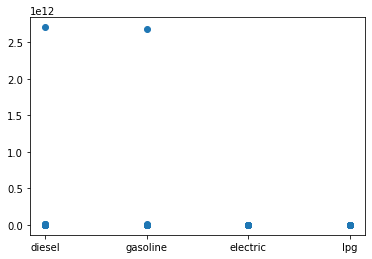

In [0]:
plt.scatter(data['fuel_type'], data['price_eur'])